In [1]:
from pprint import pprint
import time
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# Italy Index

In [2]:
italy_df=pd.read_csv("italy_index/FTSE Italia All Share Historical Data.csv")
italy_df.head()

,Date,Price,Open,High,Low,Vol.,Change %,Timestamp
0,2020-3-20,17171.55,17209.93,17628.87,17047.73,1500000000,1.85,1584662400
1,2020-3-19,16859.82,16814.38,17240.13,16438.49,1270000000,2.27,1584576000
2,2020-3-18,16486.21,16372.27,16785.57,16149.48,992760000,-1.17,1584489600
3,2020-3-17,16680.56,16850.34,17238.59,16065.72,1400000000,1.96,1584403200
4,2020-3-16,16360.04,17130.96,17130.96,15498.19,1540000000,-6.06,1584316800


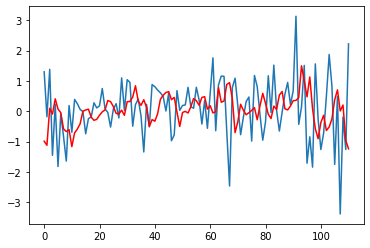

In [3]:
series=italy_df['Change %']
X=series.values
size=int(len(X)*.66)
train,test=X[0:size],X[size:len(X)]
history=[x for x in train]
predictions=list()
for t in range(len(test)):
    model=ARIMA(history,order=(5,1,0))
    model_fit=model.fit(disp=0)
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=test[t]
    history.append(obs)
error=mean_squared_error(test,predictions)
plt.plot(test)
plt.plot(predictions,color='red')
plt.show()

# S&P 500

In [4]:
curr_time = int(time.time())
prior_year = curr_time-(60*60*24*365)
ticker_symbol = "^GSPC"

In [5]:

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "c9571a29b7msh7dedf518d9ba8b2p1bf4b5jsnec4ec11b7588"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

In [6]:
timestamp = response.json()['chart']['result'][0]['timestamp']
year_close = response.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

    
snpDict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
snp_df = pd.DataFrame(snpDict)

snp_df['Change %'] = ((snp_df['Close']-snp_df['Open'])/snp_df['Open'])*100

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(snp_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(snp_df['Timestamp']))]
snp_df['Date'] = convert_date


snp_df['Last Year'] =[datetime.datetime.strptime(snp_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(snp_df['Date']))]

snp_df

,Timestamp,Open,Close,Volume,Adjclose,Change %,Date,Last Year
0,1553520600,2796.010010,2798.360107,3376580000,2798.360107,0.084052,2019-03-25,2018-03-25
1,1553607000,2812.659912,2818.459961,3266050000,2818.459961,0.206212,2019-03-26,2018-03-26
2,1553693400,2819.719971,2805.370117,3372930000,2805.370117,-0.508911,2019-03-27,2018-03-27
3,1553779800,2809.399902,2815.439941,3158170000,2815.439941,0.214994,2019-03-28,2018-03-28
4,1553866200,2828.270020,2834.399902,3740700000,2834.399902,0.216736,2019-03-29,2018-03-29
...,...,...,...,...,...,...,...,...
246,1584365400,2508.590088,2386.129883,7781540000,2386.129883,-4.881635,2020-03-16,2019-03-17
247,1584451800,2425.659912,2529.189941,8358500000,2529.189941,4.268118,2020-03-17,2019-03-18
248,1584538200,2436.500000,2398.100098,8755780000,2398.100098,-1.576027,2020-03-18,2019-03-19
249,1584624600,2393.479980,2409.389893,7946710000,2409.389893,0.664719,2020-03-19,2019-03-20


Test MSE: 3.427


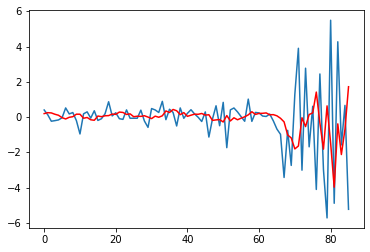

In [7]:
series=snp_df['Change %']
X=series.values
size=int(len(X)*.66)
train,test=X[0:size],X[size:len(X)]
history=[x for x in train]
predictions=list()
for t in range(len(test)):
    model=ARIMA(history,order=(5,1,0))
    model_fit=model.fit(disp=0)
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=test[t]
    history.append(obs)
error=mean_squared_error(test,predictions)
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predictions,color='red')
plt.show()

# SSE Index (Shanghai)

In [8]:
ticker_symbol = "^SSEC"
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "c9571a29b7msh7dedf518d9ba8b2p1bf4b5jsnec4ec11b7588"
    }

response_ssec = requests.request("GET", url, headers=headers, params=querystring)

In [9]:
timestamp = response_ssec.json()['chart']['result'][0]['timestamp']
year_close = response_ssec.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response_ssec.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response_ssec.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response_ssec.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

ssec_Dict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
ssec_df = pd.DataFrame(ssec_Dict)

ssec_df['Change %'] = ((ssec_df['Close']-ssec_df['Open'])/ssec_df['Open'])*100

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(ssec_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(ssec_df['Timestamp']))]
ssec_df['Date'] = convert_date


ssec_df['Last Year'] =[datetime.datetime.strptime(ssec_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(ssec_df['Date']))]

ssec_df

,Timestamp,Open,Close,Volume,Adjclose,Change %,Date,Last Year
0,1584687629,2727.018555,2745.618164,3727114220,2745.618164,0.682049,2020-03-20,2019-03-21


# Dow Jones Index

In [10]:
ticker_symbol = "^DJI"
url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/get-histories"

querystring = {"region":"US","lang":"en","symbol":ticker_symbol,"from":prior_year,"to":curr_time,"events":"div","events":"split","events":"earn","interval":"1d"}

headers = {
    'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com",
    'x-rapidapi-key': "c9571a29b7msh7dedf518d9ba8b2p1bf4b5jsnec4ec11b7588"
    }

response_DJI = requests.request("GET", url, headers=headers, params=querystring)

In [11]:
timestamp = response_DJI.json()['chart']['result'][0]['timestamp']
year_close = response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['close']
year_open =response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['open']
year_volume =response_DJI.json()['chart']['result'][0]['indicators']['quote'][0]['volume']
year_adjclose =response_DJI.json()['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

dji_Dict = {"Timestamp":timestamp,
           "Open":year_open,
          "Close":year_close,
           "Volume":year_volume,
          "Adjclose":year_adjclose
          }
dji_df = pd.DataFrame(dji_Dict)

dji_df['Change %'] = ((dji_df['Close']-dji_df['Open'])/dji_df['Open'])*100

convert_date = []
convert_date = [datetime.datetime.utcfromtimestamp(dji_df['Timestamp'][x]).strftime('%Y-%m-%d') for x in range(0,len(dji_df['Timestamp']))]
dji_df['Date'] = convert_date


dji_df['Last Year'] =[datetime.datetime.strptime(dji_df['Date'][x],'%Y-%m-%d')-datetime.timedelta(365) for x in range(0,len(dji_df['Date']))]


dji_df

,Timestamp,Open,Close,Volume,Adjclose,Change %,Date,Last Year
0,1553520600,25490.720703,25516.830078,303120000,25516.830078,0.102427,2019-03-25,2018-03-25
1,1553607000,25649.560547,25657.730469,305110000,25657.730469,0.031852,2019-03-26,2018-03-26
2,1553693400,25676.339844,25625.589844,270340000,25625.589844,-0.197653,2019-03-27,2018-03-27
3,1553779800,25693.320312,25717.460938,237170000,25717.460938,0.093957,2019-03-28,2018-03-28
4,1553866200,25827.310547,25928.679688,300620000,25928.679688,0.392488,2019-03-29,2018-03-29
...,...,...,...,...,...,...,...,...
246,1584365400,20917.529297,20188.519531,770130000,20188.519531,-3.485162,2020-03-16,2019-03-17
247,1584451800,20487.050781,21237.380859,793060000,21237.380859,3.662460,2020-03-17,2019-03-18
248,1584538200,20188.689453,19898.919922,871360000,19898.919922,-1.435306,2020-03-18,2019-03-19
249,1584624600,19830.009766,20087.189453,780300000,20087.189453,1.296922,2020-03-19,2019-03-20


Test MSE: 3.369


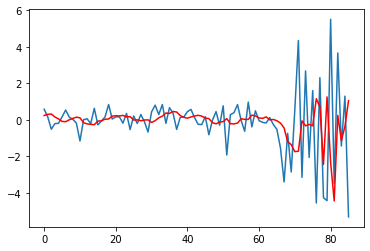

In [12]:
series=dji_df['Change %']
X=series.values
size=int(len(X)*.66)
train,test=X[0:size],X[size:len(X)]
history=[x for x in train]
predictions=list()
for t in range(len(test)):
    model=ARIMA(history,order=(5,1,0))
    model_fit=model.fit(disp=0)
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(yhat)
    obs=test[t]
    history.append(obs)
error=mean_squared_error(test,predictions)
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predictions,color='red')
plt.show()

# COVID19_Data

In [13]:
time_series_2019_ncov_Deaths =pd.read_csv("COVID19_data/time_series_2019-ncov-Deaths.csv")
time_series_2019_ncov_Recovered = pd.read_csv("COVID19_data/time_series_2019-ncov-Recovered.csv")
time_series_ncov_Confirmed = pd.read_csv("COVID19_data/time_series-ncov-Confirmed.csv")
time_series_ncov_Deaths = pd.read_csv("COVID19_data/time_series-ncov-Deaths.csv")
time_series_2019_ncov_Confirmed = pd.read_csv("COVID19_data/time_series_2019-ncov-Confirmed.csv")
time_series_2019_ncov_Recovered = pd.read_csv("COVID19_data/time_series_2019-ncov-Recovered.csv")
